# TUTORIAL 2: Find the previous layer neurons that contributed the most to the highest class probability

# Load Model, Dataset, and Functions

To summarize how our functions compose, let's look at the following summary, interpreted using this formatting rule:

*x --> y **means** function x calls function y*

---

<font color='orange'>**get_jaccard_sim**</font>(image_1, image_2, layer, topPerc) -->

<font color='blue'>**jaccard_similarity**</font>( <font color='green'>get_sorted_neurons</font>(image_1), <font color='green'>get_sorted_neurons</font>(image_2) ) -->

<font color='green'>**get_sorted_neurons**</font>(input_image, layer) -->

<font color='yellow'>**get_activations**</font>(input_image, layer)

In [ ]:
%%capture
import torch
import torchvision.models as models
from torchvision import transforms  # used for preprocessing images
from PIL import Image  
import matplotlib.pyplot as plt
import numpy as np
import os, copy

model = models.googlenet(pretrained=True)  #w/o arg, this will not pretrain it
model.eval() #set model in eval mode: https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch

# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [ ]:
%%capture
!git clone https://github.com/wlg1/analogous_neuron_circuit_expms.git

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/analogous_neuron_circuit_expms/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download iamsouravbanerjee/animal-image-dataset-90-different-animals
! unzip animal-image-dataset-90-different-animals.zip

data_dir = 'animals/animals'
f = open("name of the animals.txt", "r")
animals_list = f.readlines()
animals_list = [x.replace('\n','') for x in animals_list]

In [ ]:
def get_output(model, input_image):
    # input_image = Image.open(input)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    return output
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    # print(output[0])  # The output has unnormalized scores. To get probabilities, you can run a softmax on it.

def output_probs(model, input_image):
    output = get_output(model, input_image)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    return probabilities

def get_top_categories(probabilities, categories):
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  for i in range(top5_prob.size(0)):
      print(categories[top5_catid[i]], top5_prob[i].item())

def compare_probs(probs1, probs2, categories):
    top5_prob, top5_catid = torch.topk(probs1, 5)
    new_top5_prob, new_top5_catid = torch.topk(probs2, 5)
    for i in range(new_top5_prob.size(0)):
        row = ['before:', categories[top5_catid[i]], round(top5_prob[i].item(), 5), 'after:', categories[new_top5_catid[i]], round(new_top5_prob[i].item(), 5)]
        print("{: >10} {: >15} {: >10} {: >10} {: >15} {: >10}".format(*row))


In [ ]:
def get_activations(input_image, layer_name):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    for name_to_check, layer in model.named_modules():
        if name_to_check == layer_name:
            break
    layer.register_forward_hook(get_activation(layer_name))
    output = model(input_batch)
    return activation.copy()  #.copy(), else will return the same actvs of model

top_neurons_dict = {}

# flatten activation tensor and sort from lowest to highest
def get_sorted_neurons(input_image, layer, filename):
    actv_layer = get_activations(input_image, layer)
    flat_layer = torch.flatten(actv_layer[layer])
    sorted, indices = torch.sort(flat_layer)
    top_neurons_dict[(filename, layer)] = indices.tolist()
    return indices.tolist()

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

# a score for a pair of images
def get_jaccard_sim(image1, image2, layer, f, f_2, topPerc):
    if (f, layer) in top_neurons_dict:
        sorted_neurons_1 = top_neurons_dict[(f, layer)]
    else:
        sorted_neurons_1 = get_sorted_neurons(image1, layer, f)
    if (f_2, layer) in top_neurons_dict:
        sorted_neurons_2 = top_neurons_dict[(f_2, layer)]
    else:
        sorted_neurons_2 = get_sorted_neurons(image2, layer, f_2)
    topNum = round(len(sorted_neurons_1)*topPerc)
    return jaccard_similarity(sorted_neurons_1[-topNum:], sorted_neurons_2[-topNum:])



---
# Find previous layer neurons that contribute the most to the highest class probability

REQUIRED SECTIONS TO RUN: 
1. Load Model

CLASSIFIER (eg. Inception): find the neurons in previous layer which contributed the most to activating the class output 

match with:
https://microscope.openai.com/models/inceptionv1?models.technique=deep_dream

In [ ]:
layer = 'fc'
numSamp = 1

sample1_dir = data_dir + '/antelope'
os.listdir(sample1_dir).sort() # Since the 1st image of the animal dataset may change upon each loading of the dataset

sample1 = os.listdir(sample1_dir)[0:numSamp]
for filename in sample1:
    f = os.path.join(sample1_dir, filename)
    input_image_1 = Image.open(f)
    last_layer = get_activations(input_image_1, layer) #a dict of layername : tensor of actvs
    # sorted_neurons = get_sorted_neurons(input_image_1, layer, filename)

Find the class with highest probability

In [ ]:
topclass = torch.argmax(last_layer['fc'][0])  #https://www.tutorialspoint.com/torch-argmax-method-in-python-pytorch
topclass = topclass.item()
topclass

352

Find the probabilty of the class with highest probability

In [ ]:
last_layer['fc'][0][topclass]

tensor(11.5987, device='cuda:0')

https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

Identify class name by class ID

In [ ]:
probs = output_probs(model, input_image_1)
get_top_categories(probs, categories)

impala 0.8296818733215332
gazelle 0.1272546499967575
hartebeest 0.021986741572618484
ibex 0.0054887933656573296
long-horned beetle 0.0012612323043867946




---

## Get weights going into last layer

There are 1024 columns (neurons from previous layer) and 1000 rows (neurons in the current layer)

In [ ]:
model.fc.weight.data

Get the previous layer neurons which contributed to the highest class activation

In [ ]:
model.fc.weight.data[topclass]

tensor([-0.0303,  0.0893, -0.0009,  ..., -0.0263,  0.0377, -0.0130],
       device='cuda:0')



---

## Get activations going into last layer

W * X = A:

W[row 353] * X = A

W is 1000 x 1024

W needs to multiply with 1024 x 1 to get 1000 x 1

So X is 1024 x 1

W[row 353] is 1 x 1024, so W[row 353] * X is 1x1, the class probability that the image is Gazelle



---

Find which layer is the X, by finding which has dims 1024 x 1

In [ ]:
layer = 'dropout'
numSamp = 1

sample1_dir = data_dir + '/antelope'

sample1 = os.listdir(sample1_dir)[0:numSamp]
for filename in sample1:
    f = os.path.join(sample1_dir, filename)
    input_image_1 = Image.open(f)
    prev_layer = get_activations(input_image_1, layer) #a dict of layername : tensor of actvs

In [ ]:
prev_layer['dropout'][0].shape

torch.Size([1024])

layer = 'inception5b' : gives 1024 x 7 x 7

layer = 'dropout' : gives 1024

'inception5b.branch4.1.bn': 128 x 7 x 7

'avgpool' is 1024 x 1 x 1

So dropout is X



---
Instead of using matrix multiplication, do a Hadamard product. This will result in a vector which, when summed up and put through the Softmax function (not ReLU), will result in the class probability

https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch


In [ ]:
prev_layer['dropout'].shape

torch.Size([1, 1024])

In [ ]:
WX_topclass_hadamard = torch.multiply(prev_weights, prev_layer['dropout'][0])

In [ ]:
WX_topclass_hadamard

tensor([-0.0173,  0.0312, -0.0002,  ..., -0.0013,  0.0103, -0.0047],
       device='cuda:0')



---

### Check the hadamard is correct and when used in calculations, matches up with actual probabilities

In [ ]:
prev_weights[0] * prev_layer['dropout'][0][0] == WX_topclass_hadamard[0]  #check is doing Hadamand

tensor(True, device='cuda:0')

In [ ]:
last_layer['fc'][0][topclass]

tensor(11.5987, device='cuda:0')

In [ ]:
torch.sum(WX_topclass_hadamard)

tensor(11.6961, device='cuda:0')

This doesn't equal "last_layer['fc'][0][topclass]", so add the bias

https://stackoverflow.com/questions/64390904/how-can-i-extract-the-weight-and-bias-of-linear-layers-in-pytorch

In [ ]:
for layer in model.children():
    if isinstance(layer, torch.nn.Linear):
        # print(layer.state_dict()['weight'])
        bias = layer.state_dict()['bias']

In [ ]:
bias.shape

torch.Size([1000])

In [ ]:
bias[topclass]

tensor(-0.0974, device='cuda:0')

In [ ]:
torch.sum(WX_topclass_hadamard) + bias[topclass]

tensor(11.5987, device='cuda:0')

In [ ]:
torch.sum(WX_topclass_hadamard) + bias[topclass] == last_layer['fc'][0][topclass]

tensor(True, device='cuda:0')

Note that matrix multiplication is not the same as Hadamand, as that is Hadamand multiplication plus taking the sum of all elements in the vector, as shown below

In [ ]:
torch.matmul(prev_weights, torch.transpose(prev_layer['dropout'], 1, 0))

## this does the same thing
# torch.matmul(prev_weights, torch.transpose(prev_layer['dropout'], 0, 1))

tensor([11.6961], device='cuda:0')

---
### WX

Now do this for all weights using matrix multiplication instead of Hadamand product

In [ ]:
WX = torch.matmul(model.fc.weight.data, torch.transpose(prev_layer['dropout'], 0, 1))

In [ ]:
WX.shape

torch.Size([1000, 1])

In [ ]:
WX[topclass]

tensor([11.6961], device='cuda:0')

In [ ]:
WX_B = WX + torch.reshape(bias, (1000, 1))

In [ ]:
WX_B[topclass]

tensor([11.5987], device='cuda:0')

In [ ]:
fc = torch.reshape(last_layer['fc'][0], (1000, 1))
for i,x in enumerate(WX_B):
    if x != fc[i]:
        print(False)



---

### Get the top prev layer neurons that contributed most to class

Get the top neurons that contributed most to class, and feature viz them

In [ ]:
sorted(range(len(WX_topclass_hadamard)), key=lambda i: WX_topclass_hadamard[i])[-10:]

[91, 188, 974, 490, 487, 553, 43, 754, 1007, 592]

In [ ]:
sorted(range(len(prev_weights)), key=lambda i: prev_weights[i])[-10:]

[586, 188, 26, 411, 240, 592, 754, 487, 415, 1008]



---

# Compare prev layer activations for similar inputs vs inputs that vary at different properties

In [ ]:
def get_multi_layer_activations(input_image, list_layer_names):
    activations = {}
    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    for layer_name in list_layer_names:
        for name_to_check, layer in model.named_modules():
            if name_to_check == layer_name:
                break
        layer.register_forward_hook(get_activation(layer_name))
    output = model(input_batch)
    return activations.copy()  #else will return the same actvs of model

In [ ]:
layers_to_track = ['dropout', 'fc']
sample_actv_layers = []

sample1_dir = data_dir + '/antelope'
numSamp = 2

sample1 = os.listdir(sample1_dir)[0:numSamp]
for filename in sample1:
    f = os.path.join(sample1_dir, filename)
    input_image_1 = Image.open(f)
    actv_layers = get_multi_layer_activations(input_image_1, layers_to_track)
    sample_actv_layers.append(actv_layers)

In [ ]:
actv_layers.keys()

dict_keys(['dropout', 'fc'])

Check they're not the same

In [ ]:
actv_layers['dropout'][0] 

In [ ]:
actv_layers['fc'][0]

Check they're not the same

In [ ]:
sample_actv_layers[0]['dropout']

tensor([[0.5699, 0.3493, 0.2490,  ..., 0.0501, 0.2740, 0.3639]],
       device='cuda:0')

In [ ]:
sample_actv_layers[1]['dropout']

tensor([[0.6493, 0.3797, 0.2358,  ..., 0.5091, 0.5699, 0.2612]],
       device='cuda:0')

For the two images, get the Hadamard product of the 2nd last layer activations and weights to find which neurons contributed the most (barring bias parameters). Check if similar neurons contributed the most for the two images

In [ ]:
WX_topclass_hadamard_1 = torch.multiply(model.fc.weight.data[topclass], sample_actv_layers[0]['dropout'][0])
sorted(range(len(WX_topclass_hadamard_1)), key=lambda i: WX_topclass_hadamard_1[i])[-10:]

[91, 188, 974, 490, 487, 553, 43, 754, 1007, 592]

In [ ]:
WX_topclass_hadamard_2 = torch.multiply(model.fc.weight.data[topclass], sample_actv_layers[1]['dropout'][0])
sorted(range(len(WX_topclass_hadamard_2)), key=lambda i: WX_topclass_hadamard_2[i])[-10:]

[397, 663, 515, 747, 990, 415, 974, 1008, 487, 592]

In [ ]:
x = sorted(range(len(WX_topclass_hadamard_1)), key=lambda i: WX_topclass_hadamard_1[i])[-10:]
x.sort()
print(x)

x = sorted(range(len(WX_topclass_hadamard_2)), key=lambda i: WX_topclass_hadamard_2[i])[-10:]
x.sort()
x

[43, 91, 188, 487, 490, 553, 592, 754, 974, 1007]


[397, 415, 487, 515, 592, 663, 747, 974, 990, 1008]

In [ ]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

def get_intersection(list1, list2):
    return list(set(list1).intersection(list2))

topNum = 10
top_prevlayer_neurons_1 = sorted(range(len(WX_topclass_hadamard_1)), key=lambda i: WX_topclass_hadamard_1[i])[-topNum:]
top_prevlayer_neurons_2 = sorted(range(len(WX_topclass_hadamard_2)), key=lambda i: WX_topclass_hadamard_2[i])[-topNum:]
jaccard_similarity(top_prevlayer_neurons_1, top_prevlayer_neurons_2)

0.17647058823529413

In [ ]:
topNum = 100
top_prevlayer_neurons_1 = sorted(range(len(WX_topclass_hadamard_1)), key=lambda i: WX_topclass_hadamard_1[i])[-topNum:]
top_prevlayer_neurons_2 = sorted(range(len(WX_topclass_hadamard_2)), key=lambda i: WX_topclass_hadamard_2[i])[-topNum:]
jaccard_similarity(top_prevlayer_neurons_1, top_prevlayer_neurons_2)

0.48148148148148145

In [ ]:
get_intersection(top_prevlayer_neurons_1, top_prevlayer_neurons_2)



---
## Heatmap comparing images' most impt top neurons

Now compare to an image from another class

In [ ]:
layers_to_track = ['dropout', 'fc']
antelope_sample_actv_layers = []

sample1_dir = data_dir + '/antelope'
numSamp = 2

sample1 = os.listdir(sample1_dir)[0:numSamp]
for filename in sample1:
    f = os.path.join(sample1_dir, filename)
    input_image_1 = Image.open(f)
    actv_layers = get_multi_layer_activations(input_image_1, layers_to_track)
    antelope_sample_actv_layers.append(actv_layers)

# WX_topclass_hadamard_antelope = []
top_prevlayer_neurons_antelope = []
topNum = 100

for actv_layer in antelope_sample_actv_layers:
    WX_topclass_hadamard = torch.multiply(model.fc.weight.data[topclass], actv_layer['dropout'][0])
    top_prevlayer_neurons = sorted(range(len(WX_topclass_hadamard)), key=lambda i: WX_topclass_hadamard[i])[-topNum:]
    top_prevlayer_neurons_antelope.append(top_prevlayer_neurons)

In [ ]:
layers_to_track = ['dropout', 'fc']
badger_sample_actv_layers = []

sample1_dir = data_dir + '/badger'
numSamp = 2

sample1 = os.listdir(sample1_dir)[0:numSamp]
for filename in sample1:
    f = os.path.join(sample1_dir, filename)
    input_image_1 = Image.open(f)
    actv_layers = get_multi_layer_activations(input_image_1, layers_to_track)
    badger_sample_actv_layers.append(actv_layers)

# WX_topclass_hadamard_badger = []
top_prevlayer_neurons_badger = []
topNum = 100

for actv_layer in badger_sample_actv_layers:
    WX_topclass_hadamard = torch.multiply(model.fc.weight.data[topclass], actv_layer['dropout'][0])
    top_prevlayer_neurons = sorted(range(len(WX_topclass_hadamard)), key=lambda i: WX_topclass_hadamard[i])[-topNum:]
    top_prevlayer_neurons_badger.append(top_prevlayer_neurons)

In [ ]:
jaccard_similarity(top_prevlayer_neurons_antelope[0], top_prevlayer_neurons_antelope[1])

0.48148148148148145

Make this into a heatmap table

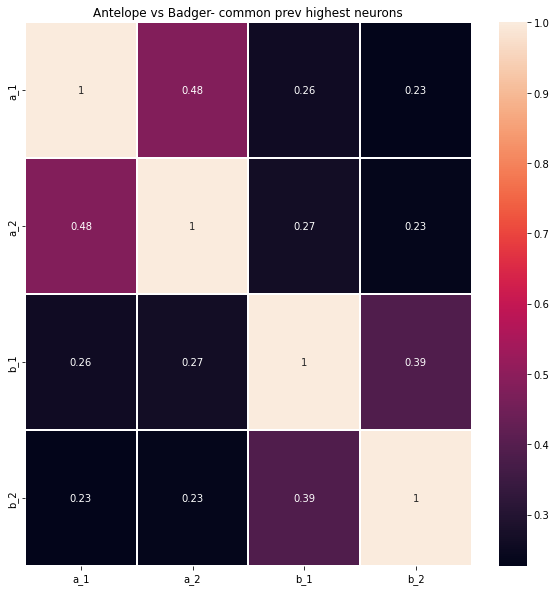

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# x-axis is each antelope image, y-axis is each badger image
# thus, each row contains an antelope. [antelope_1, antelope_2]
# 1st row: [a_1 x b_1, a_2 x b_2]
# no, this is wrong; don't just compare imgs b/w classes, but imgs within classes
# so each ind (col) in a row is an image: a_1, a_2, b_1, b_2
# each row is an image

top_prevlayer_neurons_imgs = top_prevlayer_neurons_antelope + top_prevlayer_neurons_badger

#data = np.matrix([[1, 2], [3, 4]])
heatmap = np.empty([len(top_prevlayer_neurons_imgs), len(top_prevlayer_neurons_imgs)])
for i, top_prevlayer_neurons_1 in enumerate(top_prevlayer_neurons_imgs):
    for j, top_prevlayer_neurons_2 in enumerate(top_prevlayer_neurons_imgs):
        js_score = jaccard_similarity(top_prevlayer_neurons_1, top_prevlayer_neurons_2)
        heatmap[i][j] = js_score

plt.figure(figsize=(10,10))
heat_map = sns.heatmap( heatmap, linewidth = 1 , annot = True,
                       xticklabels=['a_1', 'a_2', 'b_1', 'b_2'],
                       yticklabels=['a_1', 'a_2', 'b_1', 'b_2'])
plt.title( "Antelope vs Badger- common prev highest neurons" )
plt.show()

The quadrants along the y=x diagonal (/) are b/w category scores. The quadrants along the y=-x diagonal (\) are within category scores. As we can see, within-category scores are consistently higher than between-category scores.

The 2 quadrants along (\) are reflections of each other.



---
Try for top 200. Don't try for top 1000 because there are only 1024 neurons in the dropout layer.


In [ ]:
layers_to_track = ['dropout', 'fc']
antelope_sample_actv_layers = []

sample1_dir = data_dir + '/antelope'
numSamp = 2

sample1 = os.listdir(sample1_dir)[0:numSamp]
for filename in sample1:
    f = os.path.join(sample1_dir, filename)
    input_image_1 = Image.open(f)
    actv_layers = get_multi_layer_activations(input_image_1, layers_to_track)
    antelope_sample_actv_layers.append(actv_layers)

top_prevlayer_neurons_antelope = []
topNum = 200

for actv_layer in antelope_sample_actv_layers:
    WX_topclass_hadamard = torch.multiply(model.fc.weight.data[topclass], actv_layer['dropout'][0])
    top_prevlayer_neurons = sorted(range(len(WX_topclass_hadamard)), key=lambda i: WX_topclass_hadamard[i])[-topNum:]
    top_prevlayer_neurons_antelope.append(top_prevlayer_neurons)

In [ ]:
layers_to_track = ['dropout', 'fc']
badger_sample_actv_layers = []

sample1_dir = data_dir + '/badger'
numSamp = 2

sample1 = os.listdir(sample1_dir)[0:numSamp]
for filename in sample1:
    f = os.path.join(sample1_dir, filename)
    input_image_1 = Image.open(f)
    actv_layers = get_multi_layer_activations(input_image_1, layers_to_track)
    badger_sample_actv_layers.append(actv_layers)

top_prevlayer_neurons_badger = []
topNum = 200

for actv_layer in badger_sample_actv_layers:
    WX_topclass_hadamard = torch.multiply(model.fc.weight.data[topclass], actv_layer['dropout'][0])
    top_prevlayer_neurons = sorted(range(len(WX_topclass_hadamard)), key=lambda i: WX_topclass_hadamard[i])[-topNum:]
    top_prevlayer_neurons_badger.append(top_prevlayer_neurons)

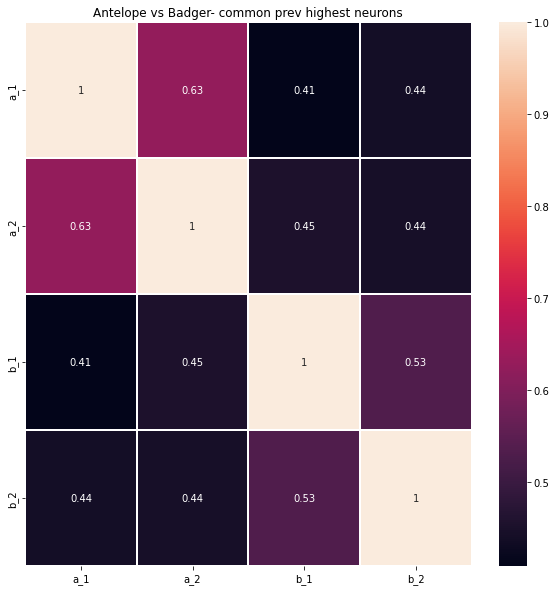

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

top_prevlayer_neurons_imgs = top_prevlayer_neurons_antelope + top_prevlayer_neurons_badger

heatmap = np.empty([len(top_prevlayer_neurons_imgs), len(top_prevlayer_neurons_imgs)])
for i, top_prevlayer_neurons_1 in enumerate(top_prevlayer_neurons_imgs):
    for j, top_prevlayer_neurons_2 in enumerate(top_prevlayer_neurons_imgs):
        js_score = jaccard_similarity(top_prevlayer_neurons_1, top_prevlayer_neurons_2)
        heatmap[i][j] = js_score

plt.figure(figsize=(10,10))
heat_map = sns.heatmap( heatmap, linewidth = 1 , annot = True,
                       xticklabels=['a_1', 'a_2', 'b_1', 'b_2'],
                       yticklabels=['a_1', 'a_2', 'b_1', 'b_2'])
plt.title( "Antelope vs Badger- common prev highest neurons" )
plt.show()

Again, there is a pattern showing that between class has lower similiarty than within-class.



---

## Keep on going backwards to previous layer to see where it breaks down


In [ ]:
layers_to_track = ['inception5b','dropout', 'fc']
badger_sample_actv_layers = []

sample1_dir = data_dir + '/badger'
numSamp = 2

sample1 = os.listdir(sample1_dir)[0:numSamp]
for filename in sample1:
    f = os.path.join(sample1_dir, filename)
    input_image_1 = Image.open(f)
    actv_layers = get_multi_layer_activations(input_image_1, layers_to_track)
    badger_sample_actv_layers.append(actv_layers)

top_prevlayer_neurons_badger = []
topNum = 200

for actv_layer in badger_sample_actv_layers:
    WX_topclass_hadamard = torch.multiply(model.fc.weight.data[topclass], actv_layer['dropout'][0])
    top_prevlayer_neurons = sorted(range(len(WX_topclass_hadamard)), key=lambda i: WX_topclass_hadamard[i])[-topNum:]
    top_prevlayer_neurons_badger.append(top_prevlayer_neurons)

In [ ]:
badger_sample_actv_layers[0]['inception5b'].shape

torch.Size([1, 1024, 7, 7])

Look at tensor dims for weights from 5b to avgpool to dropout

https://pytorch.org/vision/main/_modules/torchvision/models/inception.html

In [ ]:
model.inception5b

Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(832, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(384, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(832, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(384, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (branch3): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(832, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): 

In [ ]:
model.inception5b.branch4[1].conv

Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)

To multiply inception5b with weights,